## Part 1: Importing Libraries

In [17]:
from src.modules import data_preprocessing as dp
from src.modules import data_visualization as dv
from src.modules import modeling as md

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


## Part 2: Download Dataset

In [18]:
# Declare the ticker symbol. Here we use 5 stocks "AAPL MSFT AMD GOOG META" as an example.
tickers = "AAPL"

In [19]:
# Download the data from Yahoo Finance
df = dp.download_data(tickers)

[*********************100%%**********************]  1 of 1 completed


In [20]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-09-12,16.732143,16.978571,16.643213,16.881786,14.733599,404051200
2013-09-13,16.762142,16.851070,16.596430,16.603571,14.490784,298835600
2013-09-16,16.464287,16.486071,15.972143,16.075714,14.030096,543706800
2013-09-17,15.998571,16.418215,15.982143,16.261429,14.192177,399380800
2013-09-18,16.542143,16.655357,16.452143,16.595715,14.483922,456862000


## Part 3: EDA & Preprocessing

In [21]:
# Set global style
dv.set_global_style()

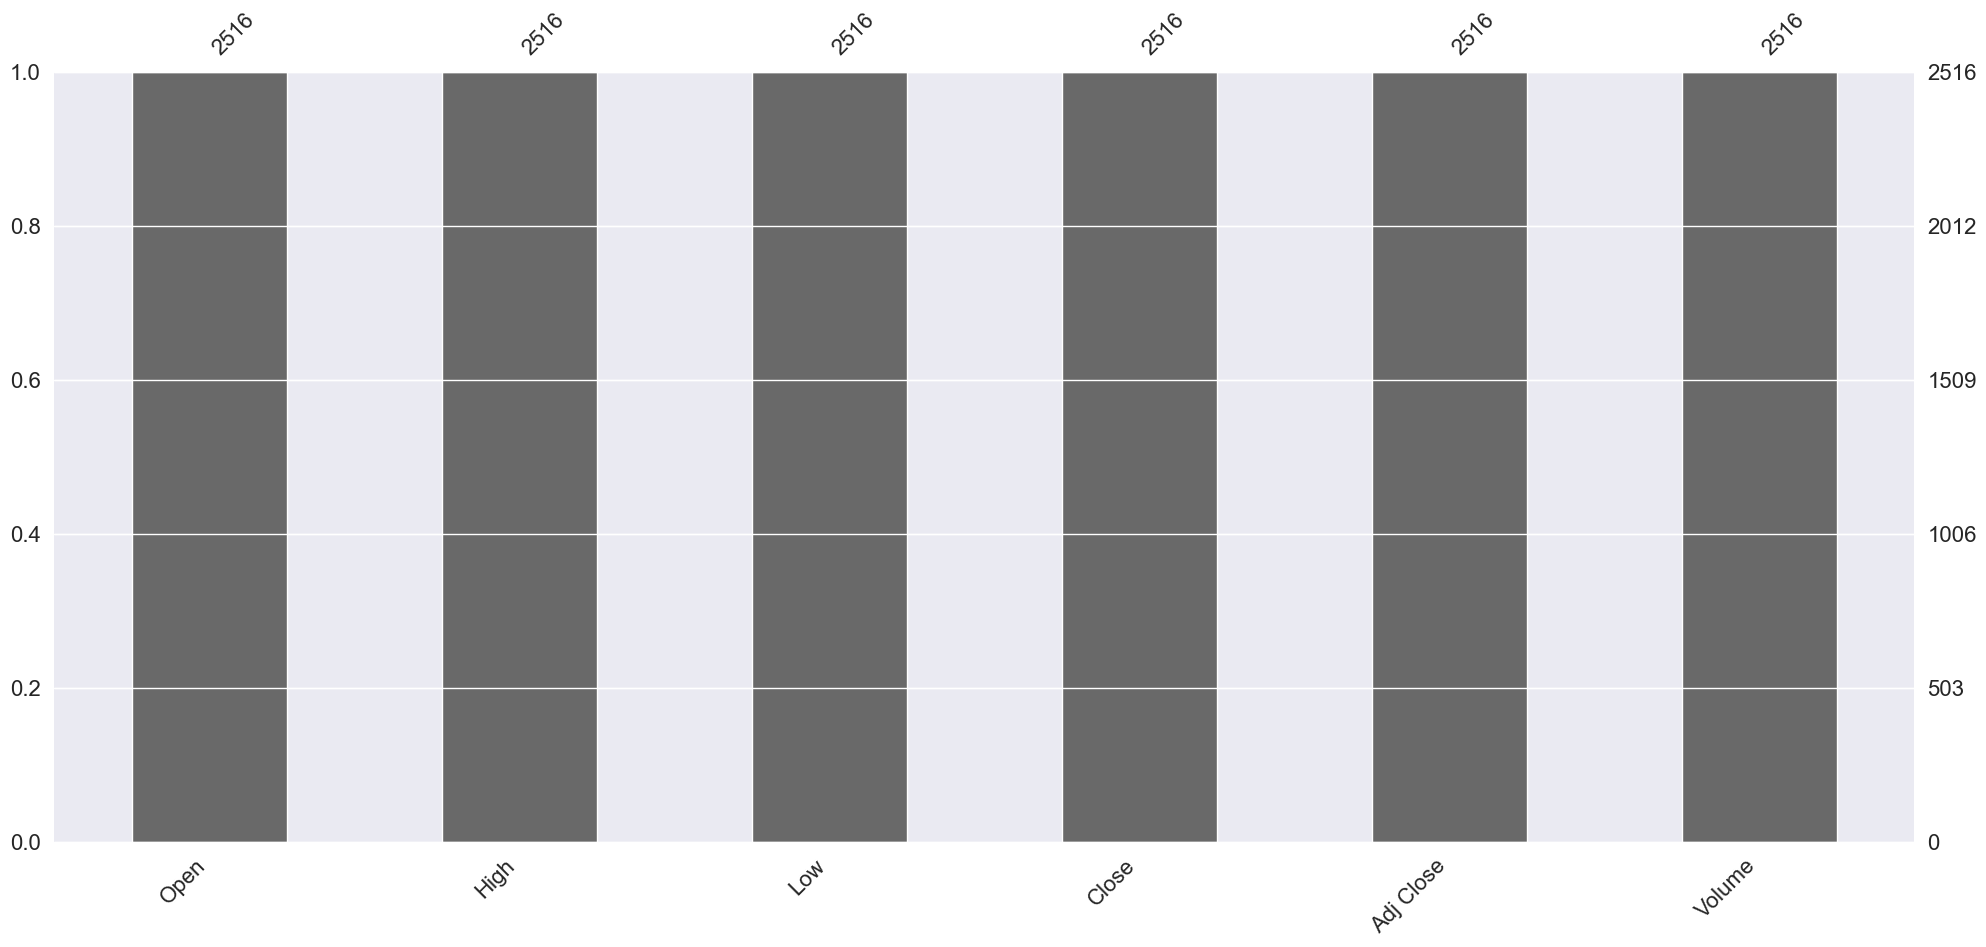

In [22]:
# Checking missing value
dv.plot_missing_values(df)

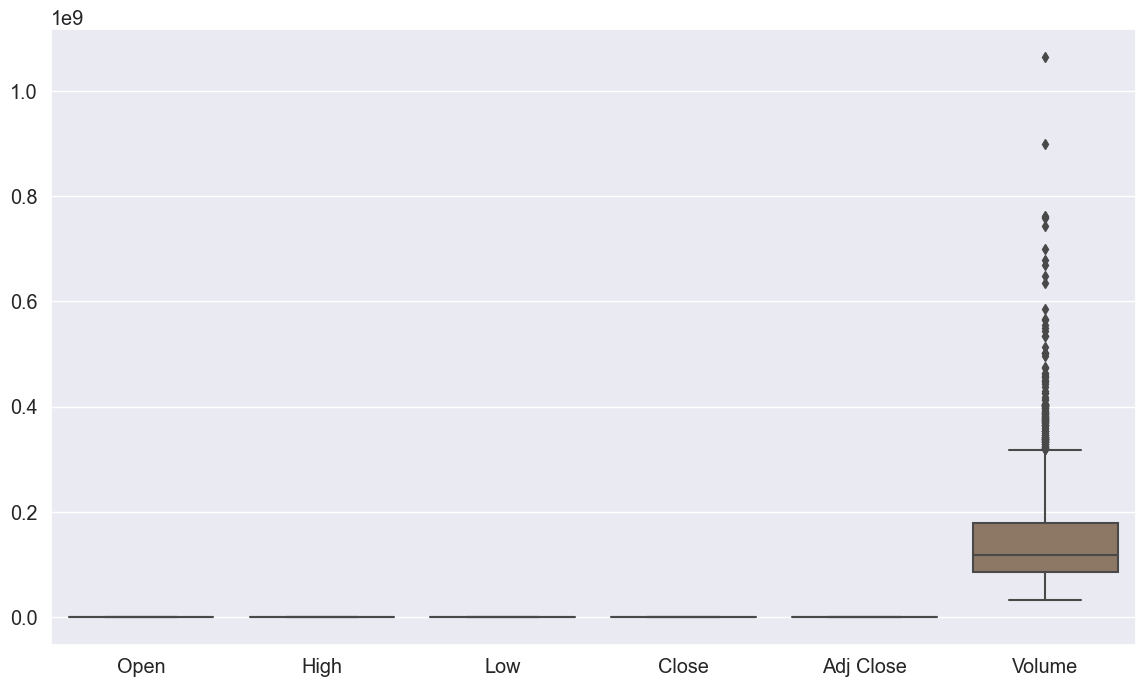

In [8]:
# Visualize the outliers data
dv.plot_outliers(df)

In [23]:
# Clean the data after checking the missing values and outliers
df = dp.clean_data(df)

## Part 4: Data Transformation

In [24]:
feat = ['adj close']

In [25]:
def scale_data(dataframe, feat):
    # get the adj close values
    close_data = dataframe.filter(feat)
    dataset = close_data.values

    # select a subset of the data for training purpose
    # the remaining set of the data is for validation
    # Get 80% of the data for training
    num_training_points = int(np.ceil(len(dataset) * 0.8))
    # X_train = dataset[0:num_training_points, :]
    # X_test = dataset[num_training_points:, :]

    # scale the data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_dataset = scaler.fit_transform(dataset)

    # split the data into train and test scaled data sets
    scaled_data_train = scaled_dataset[0:int(num_training_points), :]
    # scaled_data_test = scaled_data[int(num_training_points)-window_size:, :]

    return dataset, scaled_dataset, scaled_data_train, num_training_points, scaler

## Part 5: Feature Engineering

In [26]:
def convert_to_supervised(data, window_size=60):
    # convert the data into a supervised learning problem
    # the number of time steps to look back is the window size
    # the next day's adjusted close price is the label

    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    
    X, y = np.array(X), np.array(y)

    # reshape the data into the shape accepted by the LSTM
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y

In [27]:
# Transform the data to supervised learning
window_size = 60 # window size is the number of previous days used to predict the next day. 

In [28]:
def get_features_labels(dataframe, window_size=60):
    dataset, scaled_dataset, scaled_data_train, num_training_points, scaler = scale_data(dataframe, feat)
    features, labels = convert_to_supervised(scaled_data_train, window_size)
    return features, labels, dataset, scaled_dataset, num_training_points, scaler

## Part 6: Modeling

In [33]:
def build_and_train_model(features, labels):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(features.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    # cp = ModelCheckpoint('model/', save_best_only=True)

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    # Train the model
    # history = model.fit(features, labels, epochs = 20, batch_size = 32, verbose = 1, callbacks=[cp])
    # epoch = 10 for developoment, need to increase to 100 for real training
    history = model.fit(features, labels, epochs = 100, batch_size = 32, verbose = 1)
    return model, history

In [34]:
features, labels, dataset, scaled_dataset, num_training_points, scaler = get_features_labels(dataframe=df, window_size=60)

In [35]:
model, history = build_and_train_model(features, labels)

Epoch 1/100
62/62 [==============================] - 25s 165ms/step - loss: 0.0042 - root_mean_squared_error: 0.0652
Epoch 2/100
62/62 [==============================] - 11s 171ms/step - loss: 4.6535e-04 - root_mean_squared_error: 0.0216
Epoch 3/100
62/62 [==============================] - 11s 180ms/step - loss: 3.8111e-04 - root_mean_squared_error: 0.0195
Epoch 4/100
62/62 [==============================] - 10s 166ms/step - loss: 4.5453e-04 - root_mean_squared_error: 0.0213
Epoch 5/100
62/62 [==============================] - 10s 164ms/step - loss: 3.8432e-04 - root_mean_squared_error: 0.0196
Epoch 6/100
62/62 [==============================] - 10s 169ms/step - loss: 4.3242e-04 - root_mean_squared_error: 0.0208
Epoch 7/100
62/62 [==============================] - 10s 159ms/step - loss: 3.6809e-04 - root_mean_squared_error: 0.0192
Epoch 8/100
62/62 [==============================] - 10s 168ms/step - loss: 3.3441e-04 - root_mean_squared_error: 0.0183
Epoch 9/100
62/62 [=================

In [13]:
# Create the testing data set.
# The testing data set contains the remaining 20% of the data but we have to
# include the last 60 days from the training data set to predict the first stock price of the test data set
scaled_data_test = scaled_dataset[num_training_points - window_size:, :]

# # Create the data sets x_test and y_test
X_test = []
y_test = dataset[num_training_points:, :]

for i in range(60, len(scaled_data_test)):
    X_test.append(scaled_data_test[i-window_size:i, 0])

# Convert the values into arrays for easier computation 
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
# scaled_data_test = scaled_data[num_training_points - window_size:, :]
#X_test, y_test = convert_to_supervised(scaled_data_test, window_size)

# predict the testing data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
 
# evaluate result by mse and rmse metrics
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

16/16 [==============================] - 4s 59ms/step
MSE 75.3075347732455
RMSE 8.677991402003432


In [14]:
# Function to generate the future forecasts
def predict(n_past = 0, n_future = 5):

    # prepare data for forecasting
    forecast_data = df[['adj close']].values

    z = scaler.transform(forecast_data)

    X, y = [], []

    for i in range(window_size, len(z)):
        X.append(z[i - window_size: i])
        y.append(z[i])

    X, y = np.array(X), np.array(y)

    X_past = X[- n_past - 1:, :, :][:1]  # last observed input sequence
    y_past = y[- n_past - 1]             # last observed target value
    y_future = []                        # predicted target values

    for i in range(n_past + n_future):

        # feed the last forecast back to the model as an input
        X_past = np.append(X_past[:, 1:, :], y_past.reshape(1, 1, 1), axis=1)

        # generate the next forecast
        y_past = model.predict(X_past)

        # save the forecast
        y_future.append(y_past.flatten()[0])
  
    # transform the forecasts back to the original scale
    y_future = scaler.inverse_transform(np.array(y_future).reshape(-1, 1)).flatten()

    return y_future

In [15]:
y_pred = predict()

1/1 [==============================] - 0s 44ms/step


In [16]:
print(y_pred)

[174.08498 173.94508 173.48253 172.75319 171.82368]


In [24]:
# Save the model for future use
import pickle
pickle.dump(model,open('model_aapl.pkl','wb'))

In [19]:
model.save('aapl_model.h5')

c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
